# Objective

Our task is to predict survival of patients suffering from coronary artery disease(s) from the dataset given.

I will explore the dataset to check
- Features and the Target
- Distribution of the data
- Null/missing data (explicit or implicit)

For our pipeline to work on future unseen data, it will need to be able to handle a variety of possible inputs. Knowing the training data will allow us to put in the transformation and imputations in order to preprocess the input data to be fed into the model for it to generate good predictions.

Having a good sense of the data given I will do the following based on what I understand about the data
- feature engineering
- feature selection

Having too many features is not a good thing for a variety of reasons like overfitting on the data, training time and possibly performance of the model. I will try to see if I am able to reduce the dimensions of the features and select features to be in our model.

Lastly I will 
- create pipelines that reflect the changes made (cleaning, feature engineering,etc) and scale numerical values and encode categorical values
- come up with preliminary models 
- shortlist 2 from 5 models against validation data
- attempt to reduce dimension of the dataset
- hyper parameter tunning for shortlisted models

Out of the 2 I will choose 1 model to be deployed in production

# Imports

In [1]:
# Imports
import sqlite3 as sq3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Setting constants here
RANDOM_SEED = 42
CV = 5
TEST_RATIO = 0.5
VAL_RATIO = 0.2
DB_PATH = "Data/survive.db"

In [2]:
# Reading from database
con = sq3.Connection(DB_PATH)
query = """SELECT * FROM SURVIVE"""
df = pd.read_sql(query, con)

# EDA

| Feature | Description | Expected Value Type | Expected Example | 
| --- | --- | --- | --- |
|ID|	Unique ID for each patient| (int) | 1245 |
|Survive	| Whether Patient Survives, 0= No, 1=Yes| (int/boolean) | 0,1,Yes,No |
| Diabetes | Diabetes condition of patient | (int/boolean) | yes, No| 
|Gender	|Gender	|  (int/boolean) | 0,1,M,F |
|Smoke	|Smoker	| (int/boolean) | 0,1,Yes,No |
|Age	|Age of patient	| (int) | 32 | 
|Ejection Fraction	| Strength of heart	| (float) | 0.5 to 0.75, bounded[0,1] |  
|Sodium	|level of sodium in blood serum (mg/dL)	| (int) | 135-145 millimoles per litre (mmol/L) | 
|Creatinine	|level of Creatinine in blood serum (md/dL)	|  (int) | For adult men, 0.74 to 1.35 mg/dL , For adult women, 0.59 to 1.04 mg/dL |
|Pletelets	|Number of platelets in the blood serum (kilo-platelets/mL)	| (int) | 150K to 450K platelets per microliter of blood |
|Creatinine Phosphokinase|	level of the enzyme in the blood (mcg/L)| (int) |  10 to 120 micrograms per liter (mcg/L)
|Blood Pressure | level of blood pressure(mmHG) | (int) | systolic pressure of less than 120 and a diastolic pressure of less than 80 |
|Hemoglobin| level of hemoglobin in blood (g/dL) | (float) | For men, 13.5 to 17.5 grams per deciliter. For women, 12.0 to 15.5 grams per deciliter|
|Height| height of patient (cm)| (float) | 166cm |
|Weight| weight of patient (kg) | (float) | 58kg |
|Favourite Color | Patient's Favourite Color | (str) | blue | 

Some research was needed to form some expected values and types of the features I am going to look at. This is important because some values can be invalid without some domain knowledge. For example in a HDB dataset, a land area can be entered as square feet when it is supposed to be in square meters. Only if you are aware of the typical HDB flat size will one be able to know if the land area has issues. So as much as I can, I will need to be able to detect them and impute them as best as I can. Expected value / sensible range for features like Creatinine and other medical terms can be found in google. However as the information gathered from the internet are for normal range of values whereas the dataset consist of data from patients (possibly abnormal range), the range of values can differ.

In [3]:
# making copy of dataframe just in case
df_ori = df.copy()

Certain features like ID and favourite color has no bearing on the outcome of the patient's survivability so these will be dropped immediately.

I am assuming here that the ID does not contain valuable information in it like how our NRIC is able to inform us the year of birth.

On the color it is reasonable to assume it has no influence on survival.

In [4]:
df.drop(columns=["ID", "Favorite color"], inplace=True)

In [5]:
# Checking the dtype of features
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Survive                   15000 non-null  object 
 1   Gender                    15000 non-null  object 
 2   Smoke                     15000 non-null  object 
 3   Diabetes                  15000 non-null  object 
 4   Age                       15000 non-null  int64  
 5   Ejection Fraction         15000 non-null  object 
 6   Sodium                    15000 non-null  int64  
 7   Creatinine                14501 non-null  float64
 8   Pletelets                 15000 non-null  float64
 9   Creatinine phosphokinase  15000 non-null  int64  
 10  Blood Pressure            15000 non-null  int64  
 11  Hemoglobin                15000 non-null  float64
 12  Height                    15000 non-null  int64  
 13  Weight                    15000 non-null  int64  
dtypes: flo

Survive is the target, we have a bunch of features that are strings, some are integers and a couple of floats. We can see that feature 'Creainine' already has some explicit null values. We will check later to see if there are any implicit null values.

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,15000.0,57.428467,23.411173,-95.0,50.0,60.0,70.0,95.0
Sodium,15000.0,136.604267,4.364890,113.0,134.0,137.0,140.0,148.0
Creatinine,14501.0,1.410195,1.044535,0.5,0.9,1.1,1.4,9.4
Pletelets,15000.0,263096.016490,98056.330340,25100.0,211000.0,262000.0,304000.0,850000.0
Creatinine phosphokinase,15000.0,580.151800,955.418765,23.0,115.0,250.0,582.0,7861.0
Blood Pressure,15000.0,103.676667,39.700138,40.0,70.0,100.0,137.0,179.0
Hemoglobin,15000.0,12.910667,2.500152,9.0,10.7,12.7,15.1,17.5
Height,15000.0,159.475200,17.344439,130.0,144.0,160.0,174.0,189.0
Weight,15000.0,69.340467,25.298287,19.0,50.0,66.0,87.0,141.0


Some values already seem suspect like the height and weight. We can also see that age has negative values which is impossible. We will look at the distributions later and some sample values later.

In [7]:
df.select_dtypes(include="object").describe().T

,count,unique,top,freq
Survive,15000,4,0,9581
Gender,15000,2,Male,9757
Smoke,15000,4,No,9710
Diabetes,15000,3,Normal,8789
Ejection Fraction,15000,5,Low,12734


Looking at categorical values now, survive is our target variable and it has 4 unique values which is not what we are expecting. Smoke has similar quality. Ejection fraction was expected as a float but was given as a categorical. We will need to inspect them further.

In [8]:
df.head(10)

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
0,0,Male,Yes,Normal,50,Low,141,0.70,266000.0,185,105,12.3,180,93
1,1,Male,No,Normal,75,Low,134,2.50,224000.0,99,162,13.0,140,47
2,1,Female,No,Pre-diabetes,80,Low,135,1.30,192000.0,776,179,12.4,150,61
3,0,Male,No,Normal,-60,Low,136,0.90,228000.0,2261,136,15.3,130,48
4,0,Female,No,Normal,70,Low,141,0.90,358000.0,1202,171,13.3,177,64
5,1,Male,No,Normal,55,Low,138,1.10,314000.0,2017,88,16.5,176,58
6,1,Male,No,Normal,75,Low,134,2.50,224000.0,99,164,16.3,172,70
7,0,Female,No,Normal,65,Low,139,1.70,294000.0,326,82,14.1,167,50
8,No,Female,No,Pre-diabetes,60,Low,140,0.75,228000.0,96,83,15.5,176,94
9,1,Female,No,Normal,60,Low,127,1.70,62000.0,166,59,12.3,156,47


We see age containing negatives which was already spotted earlier.

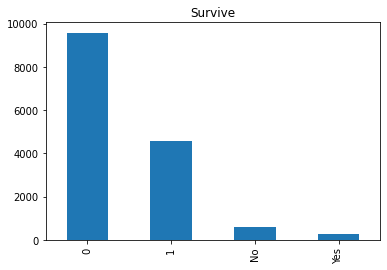

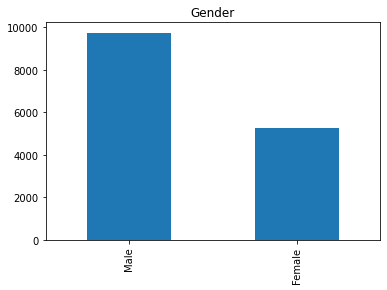

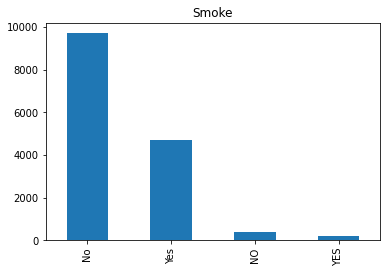

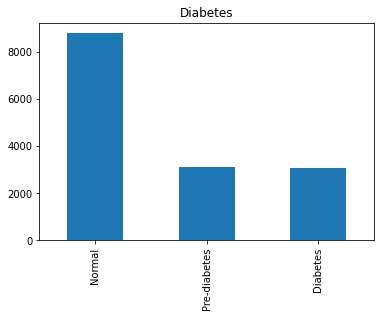

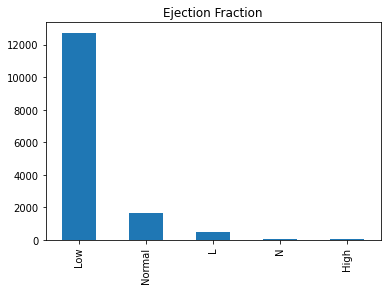

In [9]:
for col in df.select_dtypes(include="object"):
    df[col].value_counts().plot(kind="bar")
    df[col].value_counts()
    plt.title(col)
    plt.show()

We have a closer look at the categorical features. Our target feature is still binary, we just need to transform the string into numbers. The same can be done to smoke. Ejection fraction will also need some cleaning. At least our target is not severely imbalanced, which is a good thing. Otherwise I may need to oversample or undersample depending on the results.

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Sodium'}>,
        <AxesSubplot:title={'center':'Creatinine'}>],
       [<AxesSubplot:title={'center':'Pletelets'}>,
        <AxesSubplot:title={'center':'Creatinine phosphokinase'}>,
        <AxesSubplot:title={'center':'Blood Pressure'}>],
       [<AxesSubplot:title={'center':'Hemoglobin'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Weight'}>]], dtype=object)

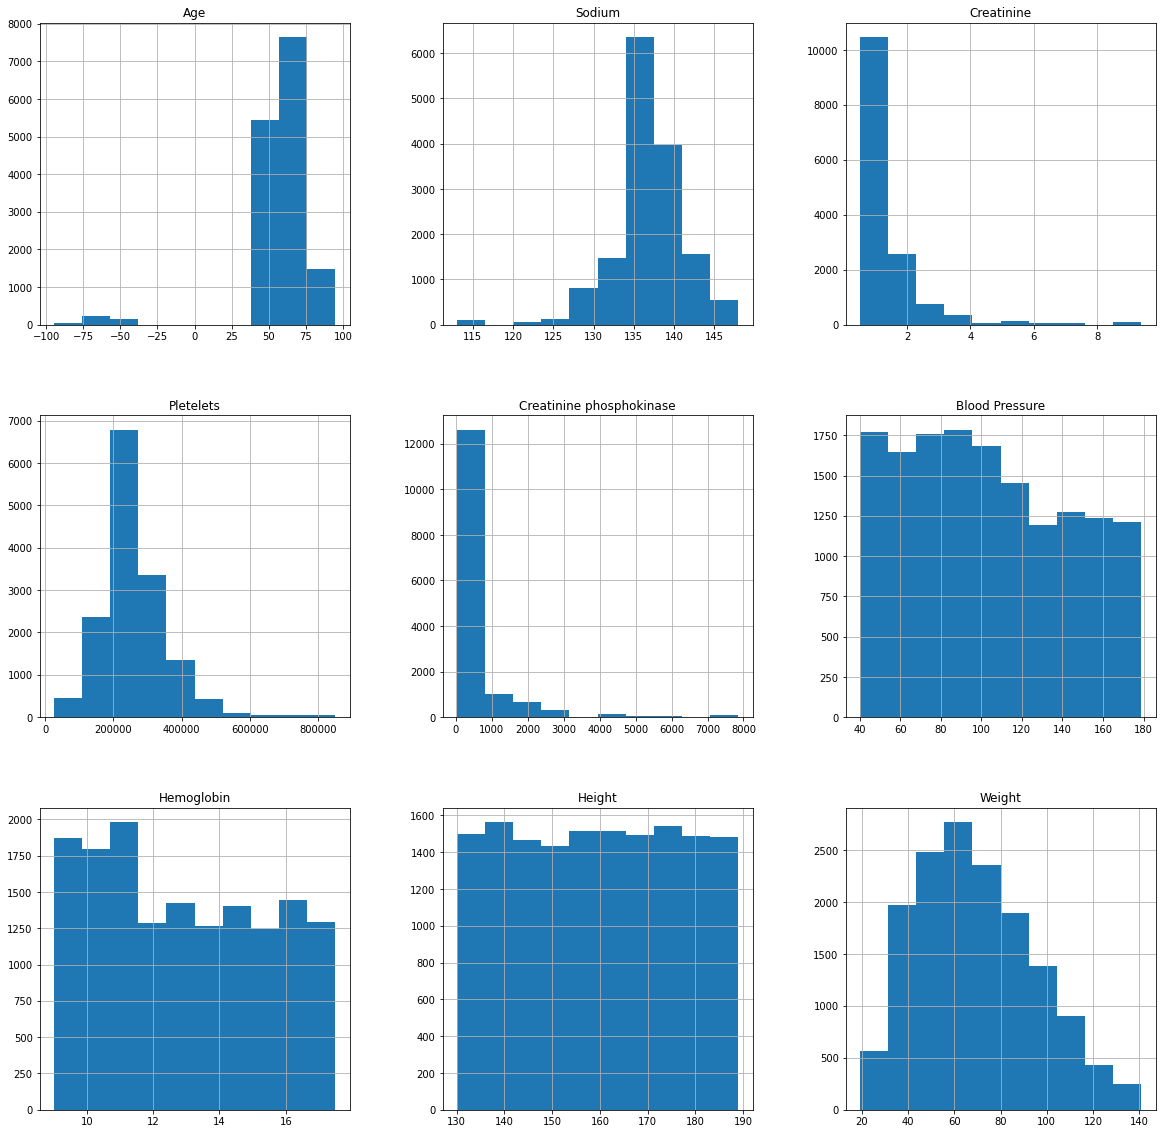

In [10]:
df.hist(figsize=(20, 20))

Looking at numerical features now, we have already seen that the age has some invalid values. My assumption here is that the value is correct but the sign is flipped. Some of the features look normal/guassian but others are tail heavy. Height and BP has a uniform distribution

In [11]:
df_ori.columns.to_list()

['ID',
 'Survive',
 'Gender',
 'Smoke',
 'Diabetes',
 'Age',
 'Ejection Fraction',
 'Sodium',
 'Creatinine',
 'Pletelets',
 'Creatinine phosphokinase',
 'Blood Pressure',
 'Hemoglobin',
 'Height',
 'Weight',
 'Favorite color']

| Feature | Observations | 
| --- | --- | 
|Survive |	mixed types present : 0,1, yes , no| 
|Gender | Seems okay|
|Smoke | inconsistent case e.g:No vs NO|
|Diabetes|Seems okay|
|Age| Some values of age appears to be invalid (min -95?).I will assume that the negative sign is a typo or some calculation error but the value is correct|
|Ejection Fraction|Categories are inconsistent|
|Sodium|Sodium appears to be in range, with some outliers|
|Creatinine| Outliers, only feature with explicit na values|
|Pletelets |Seems okay|
|Creatinine phosphokinase (CK)| Some outliers|
|Blood Pressure(BP)|Blood pressure is typically measured with 2 set of values, I'll assume it is measuring one consistently|
|Hemoglobin|Seems okay|
|Height|Lower end of height appears to be low considering age of patients|
|Weight|Some values of weight appears to be invalid (min 19kg?)|

# Cleaning up the dataset

Based on the observations above, we will clean up the features one by one in the sequence they appear in the columns starting with the target.

## Target - Survive

Problems
- mixed types present : 0,1, yes , no

For survive it is stated that if the patient survives: 0 = No , 1 = Yes, hence we will replace No to 0 and Yes to 1 instead of 0 to No and 1 to Yes since we will encode them to numbers anyway

In [12]:
df.Survive.value_counts()

0      9581
1      4552
No      604
Yes     263
Name: Survive, dtype: int64

In [13]:
df.Survive = df.Survive.str.replace("No", "0").replace("Yes", "1")

In [14]:
df.Survive.value_counts(normalize=True)

0    0.679
1    0.321
Name: Survive, dtype: float64

In [15]:
# Convert them to integer
df.Survive = df.Survive.astype("int")

The Dataset is not too imbalanced like 0.9 against 0.1.

## Gender

Gender seems okay

In [16]:
df.Gender.value_counts(normalize=True)

Male      0.650467
Female    0.349533
Name: Gender, dtype: float64

## Smoker

Problem: inconsistent case No vs NO

In [17]:
df.Smoke.value_counts()

No     9710
Yes    4707
NO      399
YES     184
Name: Smoke, dtype: int64

In [18]:
df.Smoke = df.Smoke.replace("NO", "No").replace("YES", "Yes")

In [19]:
df.Smoke.value_counts(normalize=True)

No     0.673933
Yes    0.326067
Name: Smoke, dtype: float64

## Diabetes

Seems fine as well

In [20]:
df.Diabetes.value_counts(normalize=True)

Normal          0.585933
Pre-diabetes    0.208267
Diabetes        0.205800
Name: Diabetes, dtype: float64

## Age
Problem: Some values of age appears to be invalid (min -95?), could possibly be 95 instead of -95

In [21]:
df[df.Age < 0]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
3,0,Male,No,Normal,-60,Low,136,0.90,228000.00,2261,136,15.3,130,48
14,0,Male,No,Normal,-40,Low,137,0.90,255000.00,129,82,9.1,140,37
24,1,Male,Yes,Normal,-85,Low,132,1.00,243000.00,5882,79,15.2,160,84
112,1,Male,No,Normal,-45,Low,135,1.60,126000.00,582,130,12.7,177,69
119,0,Female,No,Diabetes,-58,Normal,137,0.80,300000.00,200,53,9.1,155,71
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14937,1,Female,No,Normal,-86,Low,134,1.83,263358.03,582,58,12.8,137,57
14959,0,Male,Yes,Normal,-50,Normal,140,NaN,147000.00,582,129,14.2,143,43
14961,0,Female,No,Diabetes,-50,Low,134,1.00,279000.00,582,135,9.3,171,63
14987,0,Female,Yes,Normal,-70,Normal,140,0.80,317000.00,92,165,16.0,168,92


We have 430 rows where age is negative. I think its highly likely that they age could be positive instead without changing the value, lets see if it makes sense

<AxesSubplot:>

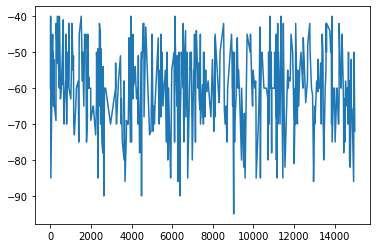

In [22]:
df[df.Age < 0].loc[:, "Age"].plot()

Their values appear to be within normal range, between 40 to 90 and not like 200 or 0. We will flip the sign.

In [23]:
# Flipping the sign if they are negative, else leave them be
df.Age = np.where(df.Age < 0, -df.Age, df.Age)

In [24]:
# check if our code is correct, it should leave no age that are negative
df[df.Age < 0]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight


<AxesSubplot:>

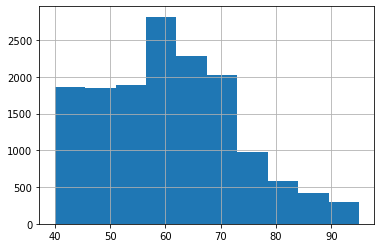

In [25]:
# Seems okay
df.Age.hist()

## Ejection Fraction
Problem : Categories are inconsistent

In [26]:
df["Ejection Fraction"].value_counts()

Low       12734
Normal     1658
L           482
N            66
High         60
Name: Ejection Fraction, dtype: int64

N should be normal, L should be L and high should remain. 

In [27]:
df["Ejection Fraction"] = (
    df["Ejection Fraction"].replace("L", "Low").replace("N", "Normal")
)

In [28]:
df["Ejection Fraction"].value_counts(normalize=True)

Low       0.881067
Normal    0.114933
High      0.004000
Name: Ejection Fraction, dtype: float64

High has too little count (0.004% ) to make a difference and will be merged together with Normal to become normal. To reflect this change I will rename Normal to Normal-High

In [29]:
df["Ejection Fraction"] = (
    df["Ejection Fraction"].replace("High", "Normal").replace("Normal", "Normal-High")
)

In [30]:
df["Ejection Fraction"].value_counts(normalize=True)

Low            0.881067
Normal-High    0.118933
Name: Ejection Fraction, dtype: float64

## Sodium
Problem: Sodium appears to be in range, with some outliers

<AxesSubplot:>

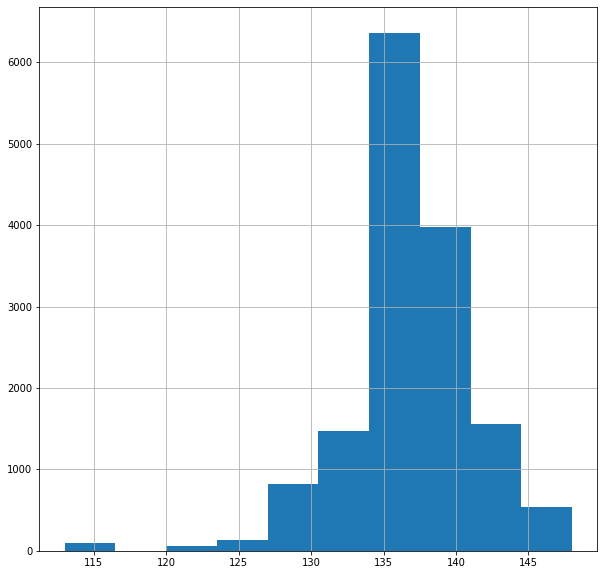

In [31]:
df.Sodium.hist(figsize=(10, 10))

In [32]:
df.Sodium.describe().T

count    15000.000000
mean       136.604267
std          4.364890
min        113.000000
25%        134.000000
50%        137.000000
75%        140.000000
max        148.000000
Name: Sodium, dtype: float64

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Sodium'>

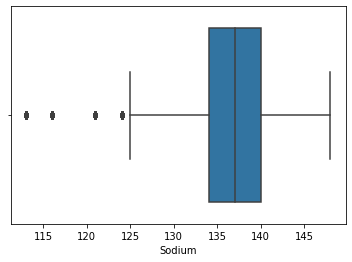

In [33]:
sns.boxplot(df.Sodium)

We have some outliers and they appear to only have 4 unqiue values. Lets eyeball them

In [34]:
df[df.Sodium < 125]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
106,1,Female,No,Diabetes,65,Low,116,2.7,327000.00,160,72,9.8,135,71
107,1,Female,No,Pre-diabetes,48,Low,121,1.9,87000.00,582,67,9.9,155,92
149,1,Female,No,Pre-diabetes,65,Low,116,2.7,327000.00,160,53,9.6,139,76
224,1,Female,No,Pre-diabetes,65,Low,116,2.7,327000.00,160,106,9.6,166,108
263,1,Female,No,Diabetes,65,Low,116,2.7,327000.00,160,54,10.9,137,74
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14509,1,Female,No,Diabetes,65,Low,116,2.7,327000.00,160,63,9.5,149,87
14636,0,Male,Yes,Diabetes,60,Low,113,1.8,263358.03,1211,59,14.3,134,38
14637,1,Female,No,Pre-diabetes,65,Low,116,2.7,327000.00,160,109,11.5,148,86
14819,1,Female,No,Diabetes,48,Low,121,1.9,87000.00,582,96,11.1,168,109


In [35]:
df[df.Sodium < 125]["Sodium"].value_counts()

121    55
116    53
113    41
124    36
Name: Sodium, dtype: int64

When it comes to outliers, I will either discard them row wise, or if the feature consists of a constant value or quasi-constant (i.e 99% of the values are the same) I will remove the entire column.

However if there are many observations that have outliers it is unwise to delete them row wise. For example in our case we have 150K observations and this outliers only represent less than 1 percent of observation, I would think that deleting them is fine as well.

Regardless I will still inspect them to see if the outliers are the result of some typo or some operation that has gone awry. In this notebook I will adopt the method of limiting them to the min and the max of the boxplot.

For this feature I'm not sure why the outliers occupy 4 unique values. But I am unable to discern any insights from these outliers. I will cap them at the minimum value. Let me define some helper functions to be consistent with my treatment of outliers unless I have other reason to deviate from this.

In [36]:
def return_min_max_boxplot(df, col, min_or_max):
    """
    Return upper(3rd quartile-1.5 of inter-quartile range) or lower(1rd quartile+1.5 of inter-quartile range).

    :param df : dataframe
    :param col: the col of the dataframe
    :param min_or_max : the upper(max) or lower(min) of the inner fence boxplot value
    :return: (float) upper(max) or lower(min) of the inner fence boxplot value
    """
    df_col_q1 = np.quantile(df[col], 0.25, method="midpoint")
    df_col_q3 = np.quantile(df[col], 0.75, method="midpoint")
    df_col_itr = df_col_q3 - df_col_q1
    df_col_min_cap = df_col_q1 - (1.5 * df_col_itr)
    df_col_max_cap = df_col_q3 + (1.5 * df_col_itr)
    if "min" in min_or_max:
        return df_col_min_cap
    else:
        return df_col_max_cap

In [37]:
def inspect_outliers(df, col):
    """
    inspects the outliers of the col of the dataframe provided,
    displaying in dataframe format of the values considered outliers
    which are beyond the inner fence boxplot values (1.5 times the inter-
    quartile range of either 1st quartile or 3rd quartile)

    :param df : dataframe
    :param col: the col of the dataframe

    :return: none
    """
    df_col_max = return_min_max_boxplot(df, col, "max")
    df_col_min = return_min_max_boxplot(df, col, "min")
    print("Values > Outer Fence \n")
    display(df[df[col] >= df_col_max])
    print("\nValue Counts")
    print(df[df[col] >= df_col_max][col].value_counts())
    print("\nValues < Outer Fence \n")
    display(df[df[col] <= df_col_min])
    print("\nValue Counts")
    print(df[df[col] <= df_col_min][col].value_counts())
    print("\nDescribe")
    print(df[col].describe().T)
    sns.boxplot(df[col])

In [38]:
def bound_outliers(df, col, boxplot=True):
    """
    Squeezes outliers to within the boxplot inner fences.

    :param df: dataframe
    :param col: the col of the dataframe
    :return: None
    """
    df_col_max = return_min_max_boxplot(df, col, "max")
    df_col_min = return_min_max_boxplot(df, col, "min")
    # For outliers, cap them at the max or min of the boxplot inner fences.
    df[col] = np.where(df[col] >= df_col_max, df_col_max, df[col])
    df[col] = np.where(df[col] <= df_col_min, df_col_min, df[col])
    if boxplot:
        sns.boxplot(df[col])

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


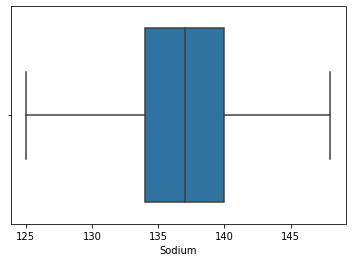

In [39]:
# bound outliers and displays outcome
bound_outliers(df, "Sodium")

## Creatinine

Problems
- Some outliers (max 9.4?)
- only feature with explicit na values

In [40]:
df["Creatinine"].isna().sum()

499

In [41]:
df[df["Creatinine"].isna()]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
23,0,Male,No,Normal,85,Low,134.0,NaN,235000.0,910,41,11.8,160,71
42,0,Male,No,Normal,70,Low,132.0,NaN,173000.0,232,87,15.1,181,62
66,0,Male,No,Pre-diabetes,70,Low,137.0,NaN,241000.0,2695,77,13.9,160,39
187,0,Female,No,Normal,65,Low,139.0,NaN,294000.0,326,49,14.0,174,54
220,0,Male,No,Diabetes,55,Low,135.0,NaN,336000.0,170,90,10.0,137,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14913,0,Male,Yes,Normal,69,Low,135.0,NaN,105000.0,1419,118,16.2,189,90
14935,0,Male,Yes,Normal,50,Low,136.0,NaN,395000.0,196,118,12.4,187,40
14959,0,Male,Yes,Normal,50,Normal-High,140.0,NaN,147000.0,582,129,14.2,143,43
14963,0,Male,Yes,Normal,53,Normal-High,133.0,NaN,220000.0,196,75,15.5,174,81


We have 499 na values. We will imput them with median value of Creatinine as mean will be weighted unevenly by outliers

In [42]:
Creatinine_median = df["Creatinine"].median()
df["Creatinine"].fillna(Creatinine_median, inplace=True)
# checking na values
df[df["Creatinine"].isna()]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight


Values > Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
1,1,Male,No,Normal,75,Low,134.0,2.5,224000.0,99,162,13.0,140,47
6,1,Male,No,Normal,75,Low,134.0,2.5,224000.0,99,164,16.3,172,70
25,0,Male,No,Diabetes,60,Low,137.0,2.3,305000.0,2656,76,12.8,186,128
54,1,Female,No,Diabetes,60,Low,132.0,2.5,196000.0,76,115,10.5,179,103
59,0,Male,No,Pre-diabetes,60,Low,137.0,2.3,305000.0,2656,85,14.2,175,113
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14957,1,Female,No,Normal,72,Low,135.0,2.5,235000.0,233,150,14.6,158,71
14965,0,Male,No,Normal,64,Low,135.0,2.4,246000.0,143,49,14.5,187,65
14966,1,Male,No,Normal,75,Low,134.0,2.5,224000.0,99,128,17.2,163,63
14967,1,Male,No,Normal,85,Low,132.0,3.0,360000.0,23,105,14.4,162,98



Value Counts
2.5    179
2.3    161
2.7    145
2.4    108
3.5    103
3.0     93
5.8     67
2.2     65
2.9     63
3.2     54
3.4     52
3.7     52
9.4     50
4.0     49
5.0     49
6.1     49
4.4     47
9.0     47
6.8     46
3.8     34
Name: Creatinine, dtype: int64

Values < Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight



Value Counts
Series([], Name: Creatinine, dtype: int64)

Describe
count    15000.000000
mean         1.399876
std          1.028518
min          0.500000
25%          0.900000
50%          1.100000
75%          1.400000
max          9.400000
Name: Creatinine, dtype: float64


C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


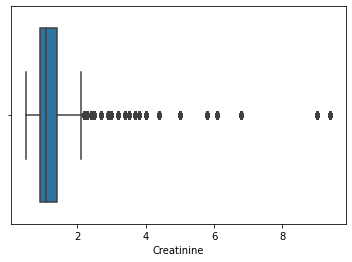

In [43]:
inspect_outliers(df, "Creatinine")

We have 1.5K plus outliers

According to https://www.emedicinehealth.com/creatinine_blood_tests/article_em.htm, 2 and above indicate abnormal readings with 5 indicating severe kidney damage. While we can assume if most of them have a pattern of entries like 9.4 which can be typos (0.94), it does not seem to be the case here. These can be actual readings without errors. I will cap them at the maximum

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


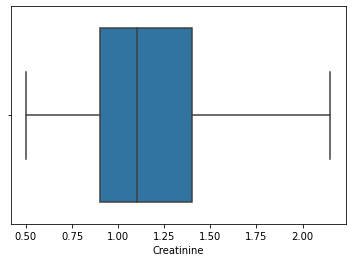

In [44]:
bound_outliers(df, "Creatinine")

## Pletelets

Values > Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
16,0,Female,No,Diabetes,70,Low,139.0,1.3,533000.0,81,145,16.0,157,46
33,0,Female,No,Diabetes,45,Low,132.0,1.0,543000.0,582,73,13.7,168,42
69,0,Female,No,Pre-diabetes,45,Normal-High,138.0,0.8,742000.0,2060,118,17.5,175,37
82,0,Male,Yes,Normal,78,Low,138.0,1.4,481000.0,224,41,15.0,133,37
100,1,Male,No,Normal,95,Low,132.0,2.0,461000.0,371,118,9.3,189,125
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14903,0,Male,Yes,Normal,78,Low,138.0,1.1,481000.0,224,70,15.9,159,53
14909,0,Female,No,Diabetes,70,Low,139.0,1.3,533000.0,81,156,12.2,135,34
14917,0,Male,Yes,Normal,78,Low,138.0,1.4,481000.0,224,111,12.2,164,56
14977,0,Male,Yes,Normal,78,Low,138.0,1.4,481000.0,224,61,13.0,156,51



Value Counts
451000.0    93
543000.0    61
481000.0    57
621000.0    56
850000.0    55
507000.0    55
454000.0    53
497000.0    50
504000.0    47
742000.0    46
448000.0    44
533000.0    43
461000.0    34
Name: Pletelets, dtype: int64

Values < Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
9,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,59,12.3,156,47
108,0,Male,No,Diabetes,70,Low,140.0,1.10,25100.0,582,116,13.3,153,36
145,0,Male,Yes,Normal,70,Low,136.0,2.15,51000.0,582,105,12.9,169,43
154,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,119,16.3,145,41
252,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,115,13.6,182,64
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14808,0,Male,Yes,Normal,70,Low,136.0,2.15,51000.0,582,116,13.0,179,48
14821,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,45,15.3,130,33
14853,0,Male,Yes,Normal,70,Low,136.0,2.15,51000.0,582,67,14.1,138,29
14876,1,Female,No,Normal,60,Low,127.0,1.70,62000.0,166,68,15.8,184,65


C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



Value Counts
62000.0    60
70000.0    55
25100.0    45
51000.0    44
47000.0    43
Name: Pletelets, dtype: int64

Describe
count     15000.00000
mean     263096.01649
std       98056.33034
min       25100.00000
25%      211000.00000
50%      262000.00000
75%      304000.00000
max      850000.00000
Name: Pletelets, dtype: float64


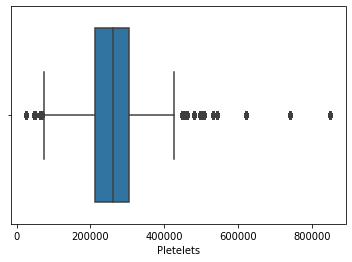

In [45]:
inspect_outliers(df, "Pletelets")

Once again, I am unable to discern any pattern and I will cap the min and max with the consistent approach.

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


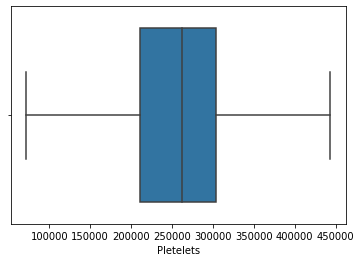

In [46]:
bound_outliers(df, "Pletelets")

## Creatinine phosphokinase

Values > Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
3,0,Male,No,Normal,60,Low,136.0,0.90,228000.0,2261,136,15.3,130,48
5,1,Male,No,Normal,55,Low,138.0,1.10,314000.0,2017,88,16.5,176,58
24,1,Male,Yes,Normal,85,Low,132.0,1.00,243000.0,5882,79,15.2,160,84
25,0,Male,No,Diabetes,60,Low,137.0,2.15,305000.0,2656,76,12.8,186,128
27,0,Male,Yes,Normal,45,Low,140.0,1.40,140000.0,2413,108,15.3,134,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14925,0,Female,No,Normal,55,Low,139.0,1.20,270000.0,1820,95,15.2,140,25
14932,0,Male,No,Pre-diabetes,60,Low,137.0,2.15,305000.0,2656,78,12.1,151,84
14940,1,Male,No,Diabetes,45,Low,139.0,1.10,334000.0,2442,78,13.2,178,86
14950,0,Male,Yes,Normal,69,Low,135.0,1.00,105000.0,1419,48,14.6,140,50



Value Counts
2413    68
1820    64
2656    62
3966    60
1419    58
2017    58
5209    57
1688    56
1896    55
2794    55
1876    55
1610    53
2695    52
2442    51
4540    49
1808    48
2281    47
1767    47
7861    47
2060    46
1846    46
3964    46
7702    46
2334    46
2261    44
1548    44
2522    43
1380    41
5882    39
Name: Creatinine phosphokinase, dtype: int64

Values < Outer Fence 



,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight


C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(



Value Counts
Series([], Name: Creatinine phosphokinase, dtype: int64)

Describe
count    15000.000000
mean       580.151800
std        955.418765
min         23.000000
25%        115.000000
50%        250.000000
75%        582.000000
max       7861.000000
Name: Creatinine phosphokinase, dtype: float64


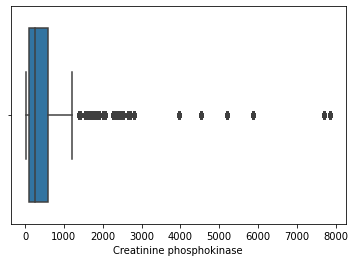

In [47]:
inspect_outliers(df, "Creatinine phosphokinase")

Once again, I am unable to discern any pattern and I will cap the min and max with the consistent approach.

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


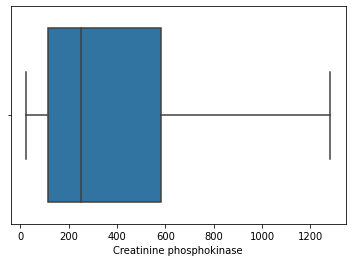

In [48]:
bound_outliers(df, "Creatinine phosphokinase")

## Blood Pressure

Problem : Blood pressure is typically measured with 2 set of values but only 1 is present without specifying which

<AxesSubplot:>

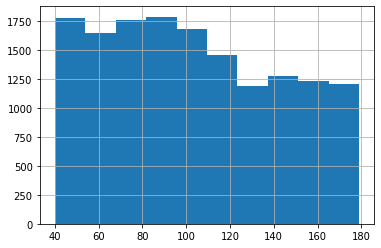

In [49]:
df["Blood Pressure"].hist()

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Blood Pressure'>

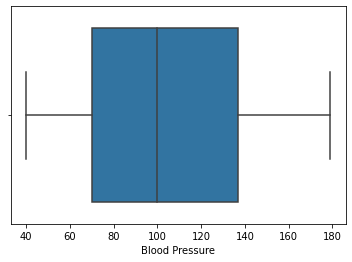

In [50]:
sns.boxplot(df["Blood Pressure"])

As I do not have medical knowledge and I am unable to identify if the BP is actually measuring diastolic or systolic pressure, I will assume it is actually measuring one of them and the measurements are done consistently. 

## Hemoglobin

Hemoglobin appears to be in range

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Hemoglobin'>

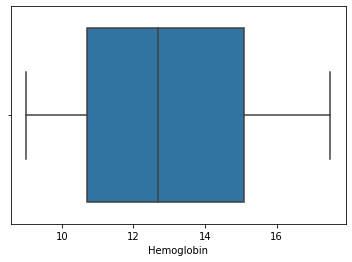

In [51]:
sns.boxplot(df.Hemoglobin)

## Height and Weight

I will inspect both height and weight together. 

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Height'>

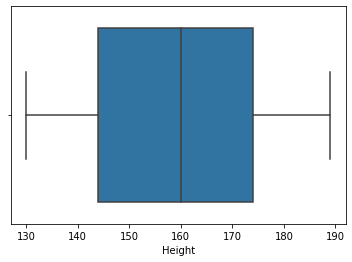

In [52]:
sns.boxplot(df.Height)

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Weight'>

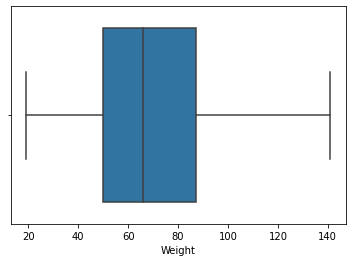

In [53]:
sns.boxplot(df.Weight)

In [54]:
df[df.Height < 140]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
3,0,Male,No,Normal,60,Low,136.0,0.90,228000.00,1282.5,136,15.3,130,48
12,0,Female,No,Normal,70,Low,141.0,0.90,358000.00,1202.0,139,16.6,132,36
17,1,Male,Yes,Normal,68,Low,140.0,0.90,289000.00,220.0,124,10.5,135,69
27,0,Male,Yes,Normal,45,Low,140.0,1.40,140000.00,1282.5,108,15.3,134,22
31,1,Male,No,Pre-diabetes,94,Low,134.0,1.83,263358.03,582.0,137,17.4,137,70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14951,0,Male,No,Diabetes,63,Low,134.0,1.30,254000.00,514.0,149,9.5,139,61
14952,0,Male,Yes,Normal,40,Low,136.0,1.10,255000.00,90.0,72,14.2,132,33
14970,0,Male,Yes,Pre-diabetes,65,Low,137.0,0.90,281000.00,198.0,171,13.9,131,44
14980,1,Male,Yes,Pre-diabetes,60,Normal-High,131.0,1.10,443500.00,315.0,66,10.4,131,67


In [55]:
df[df.Weight < 40]

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
12,0,Female,No,Normal,70,Low,141.0,0.9,358000.0,1202.0,139,16.6,132,36
14,0,Male,No,Normal,40,Low,137.0,0.9,255000.0,129.0,82,9.1,140,37
20,0,Male,No,Normal,42,Low,140.0,0.7,189000.0,64.0,109,13.2,155,37
27,0,Male,Yes,Normal,45,Low,140.0,1.4,140000.0,1282.5,108,15.3,134,22
38,0,Male,No,Normal,77,Low,137.0,1.1,406000.0,109.0,130,11.7,143,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14952,0,Male,Yes,Normal,40,Low,136.0,1.1,255000.0,90.0,72,14.2,132,33
14955,0,Male,Yes,Pre-diabetes,63,Low,136.0,0.9,179000.0,103.0,113,11.5,150,29
14962,0,Male,No,Pre-diabetes,40,Low,132.0,1.0,222000.0,582.0,43,15.2,154,37
14983,0,Male,No,Normal,42,Low,140.0,0.7,189000.0,64.0,104,16.5,148,34


In [56]:
pd.DataFrame(df.iloc[27]).T

,Survive,Gender,Smoke,Diabetes,Age,Ejection Fraction,Sodium,Creatinine,Pletelets,Creatinine phosphokinase,Blood Pressure,Hemoglobin,Height,Weight
27,0,Male,Yes,Normal,45,Low,140.0,1.4,140000.0,1282.5,108,15.3,134,22


Some values appear to be suspect like weight around 20kg and height around 130cm. However I will assume that the values are correct and inspect BMI instead.

# Feature Engineering

Without any domain knowledge, I am unable to come up with any specific features except for BMI.

## BMI

As mentioned,seeing how in medical usage they are usually inspected as BMI instead of individually, I will introduce new feature BMI. I will see if the values are odd

Formula for BMI is [weight (kg) / height (cm) / height (cm)] x 10,000

In [57]:
df["BMI"] = (df.Weight / df.Height / df.Height) * 10000

Normal range for BMI is 18.5 to 24.9

C:\Users\Randy\Venv\aiap\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='BMI'>

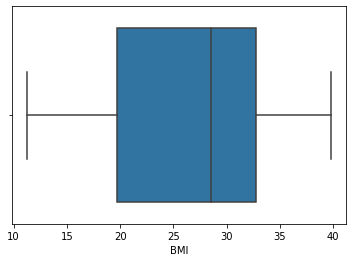

In [58]:
sns.boxplot(df.BMI)

<AxesSubplot:>

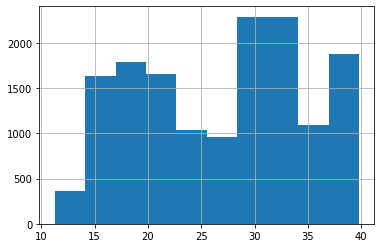

In [59]:
df.BMI.hist()

In [60]:
df.BMI.describe()

count    15000.000000
mean        26.939831
std          7.734126
min         11.242604
25%         19.675167
50%         28.493704
75%         32.713499
max         39.795918
Name: BMI, dtype: float64

This appears more to be in order

# Feature Selection

<AxesSubplot:>

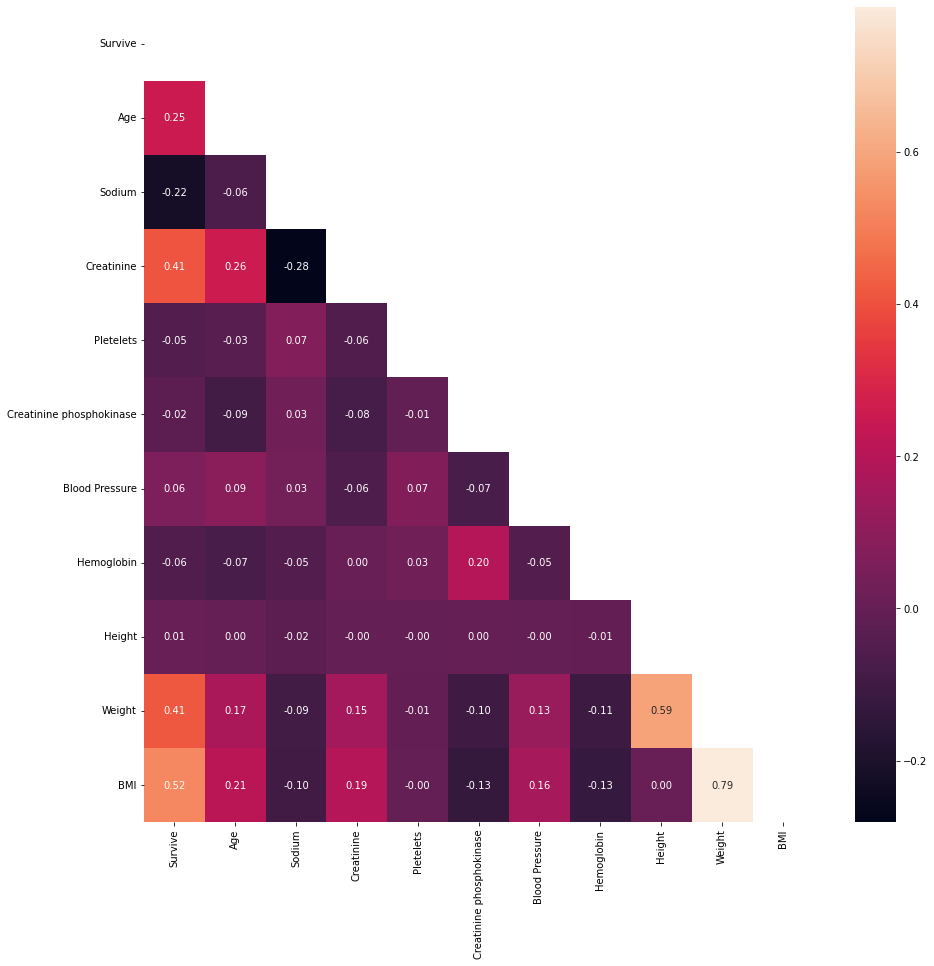

In [61]:
fig = plt.figure(figsize=(15, 15))
mask = np.triu(df.corr())
sns.heatmap(df.corr(), annot=True, fmt=".2f", mask=mask)

If any pair of features correlate strongly with each other, it is possible to remove them since both are providing more or less the same information. We see that the features do not correlate with each other highly. 

# Pipeline

In [62]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

<b>All changes that was done</b>

| Feature | Transformation |
| --- | ---|
| Target | replaced No and Yes to 0 and 1 , convert to int|
| Smoke | replaced NO to no, YES to Yes|
| Age | flipped sign if negative|
|Ejection | Made categories consistent, merged normal and high together|
| BMI | Created from weight and height|

We will perform the following for all numerical features:  Sodium, Creatinine, Pletelets, CK,Blood Pressure, Hemoglobin, Height , Weight

Numerical features
- Bound all outliers
- impute with median if missing



In [63]:
TARGET = ["Survive"]

CAT_FEATURES = ["Gender", "Smoke", "Diabetes", "Ejection Fraction"]

ORI_NUM_FEATURES = [
    "Sodium",
    "Creatinine",
    "Pletelets",
    "Creatinine phosphokinase",
    "Blood Pressure",
    "Hemoglobin",
    "Height",
    "Weight",
]
TOTAL_NUM_FEATURES = [
    "Sodium",
    "Creatinine",
    "Pletelets",
    "Creatinine phosphokinase",
    "Blood Pressure",
    "Hemoglobin",
    "Height",
    "Weight",
    "BMI",
]

TOTAL_FEATURES = CAT_FEATURES + TOTAL_NUM_FEATURES
TOTAL_FEATURES_W_TARGET = TOTAL_FEATURES + TARGET

In [64]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [65]:
transform_pipe = ColumnTransformer(
    [
        ("ss", StandardScaler(), TOTAL_NUM_FEATURES),
        ("ohe", OneHotEncoder(drop="first"), CAT_FEATURES),
    ]
)

We will need to scale the numerical features as some algorithims will work better with scaled features. It can allow faster convergents with smaller numbers since its really the magnitude between the observations that we want to capture.

As machine learning is unable to operate with strings, we will need to encode them into integers. Unless there is reason to do so, I tend to one hot encode because there is no ordinal value in the values themselves.

Column Transformer allows me to transform with selected columns

In [66]:
y = df.pop("Survive")
X = df

Splitting the dataset into the dependent (y) and the indepedent variables (X).

In [67]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=VAL_RATIO, random_state=RANDOM_SEED
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=TEST_RATIO, random_state=RANDOM_SEED
)

I split them into training, validation and test sets. Training set is for training, validation set is for comparing models and testing set is for final evaluation of the shortlisted model.

In [68]:
print(f"Shape of X_train is {X_train.shape}")
print(f"Shape of X_val is {X_val.shape}")
print(f"Shape of X_test is {X_test.shape}")
print(f"Shape of y_train is {y_train.shape}")
print(f"Shape of y_val is {y_val.shape}")
print(f"Shape of y_test is {y_test.shape}")

Shape of X_train is (12000, 14)
Shape of X_val is (1500, 14)
Shape of X_test is (1500, 14)
Shape of y_train is (12000,)
Shape of y_val is (1500,)
Shape of y_test is (1500,)


Checking the shape of the splits..

# Modelling

The models used to train were chosen based on how complex the models are, whether they are ensemble models or not and where it is instance or model based.

As this is a classification problem, scores like recall, precision, accuracy, F1 score and the ROC AUC score are relevant

In [69]:
# Models
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Metrics
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_validate
import time

In [70]:
lgbm = LGBMClassifier(random_state=RANDOM_SEED)
rfc = RandomForestClassifier(random_state=RANDOM_SEED)
svc = SVC(random_state=RANDOM_SEED)
knn = KNeighborsClassifier()
logreg = LogisticRegression()

In [71]:
# Merging the transform pipeline from above with an estimator at the end
survive_pipe_lgbm = Pipeline([("transform", transform_pipe), ("lgbm", lgbm)])
survive_pipe_rfc = Pipeline([("transform", transform_pipe), ("rfc", rfc)])
survive_pipe_svc = Pipeline([("transform", transform_pipe), ("svc", svc)])
survive_pipe_knn = Pipeline([("transform", transform_pipe), ("knn", knn)])
survive_pipe_logreg = Pipeline([("transform", transform_pipe), ("logreg", logreg)])

In [72]:
# Setting up a dictionary so I can make a comparison in one call later
pipeline_dict = {
    survive_pipe_rfc: "rfc",
    survive_pipe_svc: "svc",
    survive_pipe_lgbm: "lgbm",
    survive_pipe_knn: "knn",
    survive_pipe_logreg: "logreg",
}

In [73]:
def compare_models(pipeline_dict):
    """
    Plots the relevant metrics of the models contained in pipeline_dict
    
    :params:pipeline_dict (dict): Dictionary of pipelines with key as pipeline and value as the model name
    :returns: None
    """
    for pipe, model_name in pipeline_dict.items():
        now = time.time()

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_val)

        model_cv_score = cross_validate(
            pipe,
            X_train,
            y_train,
            cv=CV,
            n_jobs=-1,
            return_train_score=True,
            scoring="accuracy",
        )

        print("")
        print("\n" + str("*" * 50))
        print("Model is ", model_name)
        print("*" * 50)

        print(f"Classifcation report :\n{classification_report(y_val, y_pred)}")
        print(f'Average CV train acc score : \n {model_cv_score["train_score"].mean()} ')
        print(f'Average CV test acc score : \n {model_cv_score["test_score"].mean()} ')
        print(f"ROC AUC score :\n {roc_auc_score(y_val, y_pred)}")
        then = time.time()
        diff = then - now
        print(f"Seconds taken to run results is {diff}")

In [74]:
compare_models(pipeline_dict)



**************************************************
Model is  rfc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       996
           1       1.00      1.00      1.00       504

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

Average CV train acc score : 
 1.0 
Average CV test acc score : 
 0.9999166666666668 
ROC AUC score :
 1.0
Seconds taken to run results is 3.816547393798828


**************************************************
Model is  svc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.95      0.98      0.96       996
           1       0.96      0.89      0.92       504

    accuracy                           0.95      1500
   macro avg    

Time is used as another metric to compare the models. I need the train score to be returned from cross validation so that I can determine if the model is overfitting on the training data. We see some slight overfitting but thats fine.

I trained the training set on all of the classifiers and used the validation set to shortlist some models. Clearly the ensemble models like random forest and light gbm has beaten the rest of them with models like knn and svc not doing too badly with the linear model - logreg performing the worst.

This is great news as I do not need to do hyperparameter tunning.

In [75]:
shortlist_dict =  {
    survive_pipe_rfc: "rfc",
    survive_pipe_lgbm: "lgbm",
}

In [76]:
for pipe, model_name in shortlist_dict.items():
    now = time.time()
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    print("\n" + str("*" * 50))
    print("Model is ", model_name)
    print("*" * 50)

    print(f"Classifcation report :\n{classification_report(y_test, y_pred)}")
    print(f"ROC AUC score :\n {roc_auc_score(y_test, y_pred)}")
    then = time.time()
    diff = then - now
    print(f"Time taken to run results is {diff}")


**************************************************
Model is  rfc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00       490

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500

ROC AUC score :
 1.0
Time taken to run results is 1.019745111465454

**************************************************
Model is  lgbm
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1010
           1       1.00      1.00      1.00       490

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      150

At this point either one is fine but I chose Random Forest in the end because there was some issue implementing lgbm in the pipeline later.

# Second iteration

We can look at the feature importance to see which feature had a higher weightage than the rest. We can then use these features to determine a better model if possible.

In [77]:
rfc.feature_importances_.sum()

1.0

In [78]:
def show_feature_importance(model, X_train,name):
    """
    Plots the feature importance from the model against the column names
    
    :param: model : the model which was trained on the data
    :param: name : name of plot
    :param: X_train : X_train that was used to to extract the cols
    
    returns: None
    """
    important_features = pd.Series(data=model.feature_importances_, index=X_train.columns)
    important_features.sort_values(ascending=False, inplace=True)
    important_features.plot(kind="bar", title = name, ylabel = 'Importance')

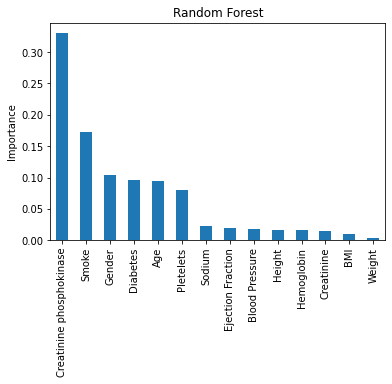

In [79]:
show_feature_importance(rfc, X_train, 'Random Forest')

This shows that there are 5 features that contribute the most to the prediction.

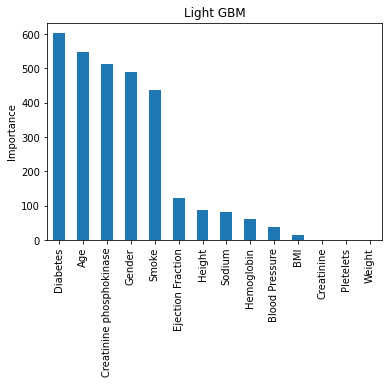

In [80]:
show_feature_importance(lgbm,X_train, 'Light GBM')

This is echoed by another ensemble model that showed the 5 most important features. Turns out our created feature of BMI was not that great after all.

In [81]:
X_train.columns.to_list()

['Gender',
 'Smoke',
 'Diabetes',
 'Age',
 'Ejection Fraction',
 'Sodium',
 'Creatinine',
 'Pletelets',
 'Creatinine phosphokinase',
 'Blood Pressure',
 'Hemoglobin',
 'Height',
 'Weight',
 'BMI']

Lets see if we are able to have a model that will come out with identical results with about half of the original features.

In [82]:
SELECTED_FEATURES = ['Creatinine phosphokinase', 'Smoke','Gender','Diabetes','Age']

In [83]:
transform_pipe_2 = ColumnTransformer(
    [
        ("ss", StandardScaler(), ['Age']),
        ("ohe", OneHotEncoder(drop="first"), ['Creatinine phosphokinase', 'Smoke','Gender','Diabetes']),
    ]
)

In [84]:
# Merging the transform pipeline from above with an estimator at the end
survive_pipe_lgbm_2 = Pipeline([("transform", transform_pipe_2), ("lgbm", lgbm)])
survive_pipe_rfc_2 = Pipeline([("transform", transform_pipe_2), ("rfc", rfc)])
survive_pipe_svc_2 = Pipeline([("transform", transform_pipe_2), ("svc", svc)])
survive_pipe_knn_2 = Pipeline([("transform", transform_pipe_2), ("knn", knn)])
survive_pipe_logreg_2 = Pipeline([("transform", transform_pipe_2), ("logreg", logreg)])

In [85]:
# Setting up a dictionary so I can make a comparison in one call later
pipeline_dict2 = {
    survive_pipe_rfc_2: "rfc",
    survive_pipe_svc_2: "svc",
    survive_pipe_lgbm_2: "lgbm",
    survive_pipe_knn_2: "knn",
    survive_pipe_logreg_2: "logreg",
}

Same transformation but with lesser features....

In [86]:
compare_models(pipeline_dict2)



**************************************************
Model is  rfc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       996
           1       0.96      0.98      0.97       504

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

Average CV train acc score : 
 0.976125 
Average CV test acc score : 
 0.9736666666666667 
ROC AUC score :
 0.9805292598967298
Seconds taken to run results is 3.1638002395629883


**************************************************
Model is  svc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.95      0.96      0.96       996
           1       0.92      0.90      0.91       504

    accuracy                           0.94      

C:\Users\Randy\Venv\aiap\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(




**************************************************
Model is  logreg
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.86      0.96      0.91       996
           1       0.89      0.69      0.78       504

    accuracy                           0.87      1500
   macro avg       0.87      0.82      0.84      1500
weighted avg       0.87      0.87      0.86      1500

Average CV train acc score : 
 0.87675 
Average CV test acc score : 
 0.8744166666666666 
ROC AUC score :
 0.8241418053165042
Seconds taken to run results is 0.5380070209503174


I shortlist the ensemble methods again. Let me try to use hyperparameter tunning to acheive better results.

## Hyperparamter Tunning

In [87]:
from sklearn.model_selection import GridSearchCV

In [88]:
# Merging the transform pipeline from above with an estimator at the end
survive_pipe_lgbm_2 = Pipeline([("transform", transform_pipe_2), ("lgbm", lgbm)])
survive_pipe_rfc_2 = Pipeline([("transform", transform_pipe_2), ("rfc", rfc)])
survive_pipe_svc_2 = Pipeline([("transform", transform_pipe_2), ("svc", svc)])
survive_pipe_knn_2 = Pipeline([("transform", transform_pipe_2), ("knn", knn)])
survive_pipe_logreg_2 = Pipeline([("transform", transform_pipe_2), ("logreg", logreg)])

In [89]:
params_rfc = {'rfc__n_estimators': range(50,250,50),
             'rfc__random_state': [RANDOM_SEED]}
params_lgbm = {'lgbm__random_state': [RANDOM_SEED],
              'lgbm__n_estimators': range(250,550,50)}
pipeline_short = {
    survive_pipe_rfc_2: "rfc",
    survive_pipe_lgbm_2: "lgbm" 
}
params_dict = {'rfc' : params_rfc,
              'lgbm': params_lgbm}

There is not much to tune except to increase the number of estimators as I want to increase the complexity of the models.

In [90]:
for pipe,model_name in pipeline_short.items():
    now = time.time()
    
    params = params_dict.get(model_name)
    
    gs = GridSearchCV(pipe, params,
        cv=CV,
        n_jobs=-1,
        return_train_score=True,
        scoring="accuracy",
    )
    
    gs.fit(X_train, y_train)
    y_pred = gs.predict(X_val)

    print("")
    print("\n" + str("*" * 50))
    print("Model is ", model_name)
    print("*" * 50)

    print(f"Classifcation report :\n{classification_report(y_val, y_pred)}")
    print(f'Average CV train acc score : \n {gs.cv_results_["mean_train_score"].mean()} ')
    print(f'Average CV test acc score : \n {gs.cv_results_["mean_test_score"].mean()} ')
    print(F'Best Params : \n {gs.best_params_}' )
    print(f"ROC AUC score :\n {roc_auc_score(y_val, y_pred)}")
    then = time.time()
    diff = then - now
    print(f"Seconds taken to run results is {diff}")



**************************************************
Model is  rfc
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       996
           1       0.96      0.98      0.97       504

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

Average CV train acc score : 
 0.976125 
Average CV test acc score : 
 0.9736458333333333 
Best Params : 
 {'rfc__n_estimators': 100, 'rfc__random_state': 42}
ROC AUC score :
 0.9805292598967298
Seconds taken to run results is 7.043081521987915


**************************************************
Model is  lgbm
**************************************************
Classifcation report :
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       996
           1       0.96      0.98   

While the shortlisted models are able to work on a dataset with fewer features to realise very comparable results to another dataset with almost twice the number of features, the small amount of recall or accuracy that is missing could mean a big difference if this model where to be deployed in real life. I guess depending on the business requirements this may be acceptable, however I would choose to use the full set of features for a small percentage increase as the result of a false negative could be disastrous.

Another way to approach this is also to encompass more features to keep increasing the accuracy. Either lgbm or rfc is fine, but I will pick rfc because I have issue deploying the lgbm.

# Miscellanous

Taking a sample of the data for testing

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Sodium'}>,
        <AxesSubplot:title={'center':'Creatinine'}>],
       [<AxesSubplot:title={'center':'Pletelets'}>,
        <AxesSubplot:title={'center':'Creatinine phosphokinase'}>,
        <AxesSubplot:title={'center':'Blood Pressure'}>],
       [<AxesSubplot:title={'center':'Hemoglobin'}>,
        <AxesSubplot:title={'center':'Height'}>,
        <AxesSubplot:title={'center':'Weight'}>],
       [<AxesSubplot:title={'center':'BMI'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

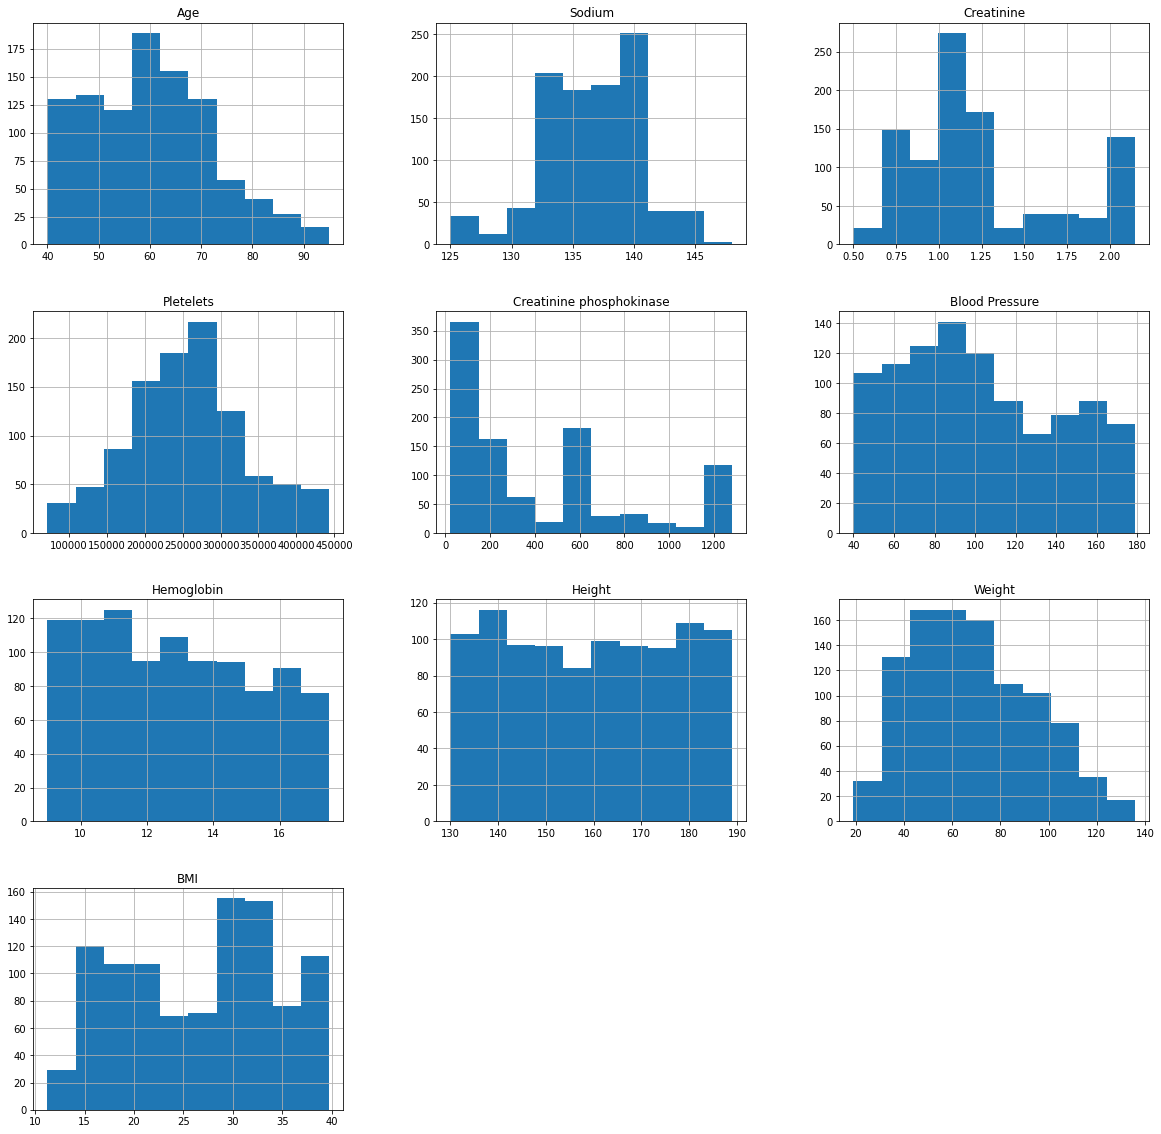

In [91]:
df[:1000].hist(figsize=(20,20))

First 1K worth of data appears to have similar distribution to the original dataset which we will take for testing purposes

In [92]:
df[:1000].to_csv('sample_df.csv')